# CSE 291 Assignment 2 BiLSTM CRF

## Download Data/Eval Script

In [1]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import conlleval
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

torch.manual_seed(291)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preparation

In [2]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = Vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
label_vocab = Vocab(train_label_counter, specials=(), min_freq=1)
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))
tag_to_ix = {"O": 0, "I-PER": 1, "I-ORG": 2, 'I-LOC': 3, 'I-MISC': 4, 'B-MISC': 5,'B-ORG': 6,'B-LOC': 7, START_TAG: 8, STOP_TAG: 9}
print(len(tag_to_ix))

Train word vocab: 3947 symbols.
Train label vocab: 8 symbols: ['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
Train data: 3420 sentences.
Valid data: 800
Pusan 0000 0000 0000 0000 0000 0000
I-ORG O O O O O O
Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north .
O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O
10


## BiLSTMTagger

In [3]:
# Starter code implementing a BiLSTM Tagger
# which makes locally normalized, independent
# tag classifications at each time step

class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMTagger, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        # logistic regression
        print("hidden_dim: ", hidden_dim)
        print("target_size: ", tag_vocab_size)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.word_embeds(sentence)
        #print(embeds.shape)
        #print(embeds)
        embeds = self.dropout(embeds)
        
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        #print('before dropout: ', bilstm_out.shape)
        bilstm_out = self.dropout(bilstm_out)
        #print('after dropout: ', bilstm_out.shape)
        #print(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        return bilstm_feats

    def forward(self, sentence):
        #input a sequence of tag, perform lstm and then logistic regression
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        #print('forward: ',bilstm_feats.shape)
        #print('second: ', bilstm_feats.argmax(-1))
        return bilstm_feats.max(-1)[0].sum(), bilstm_feats.argmax(-1)

    # compute the NLL -> negative likelyhood loss
    def loss(self, sentence, tags):
        #print('sentence length: ', sentence.shape)
        #print('tags length: ', tags.shape)
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        #print('loss: ', bilstm_feats.shape )
        # transform predictions to (n_examples, n_classes) and ground truth to (n_examples)
        return torch.nn.functional.cross_entropy(
              bilstm_feats.view(-1, self.tagset_size), 
              tags.view(-1), 
              reduction='sum'
            )


## Train / Eval loop

In [4]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [7]:
class BiLSTMTagger3(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMTagger3, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
       
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.dropout = nn.Dropout(p=dropout)
        
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))
        
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas
        #print(feats.shape)
        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                #print(next_tag)
                #print('fests shape', feats.shape)
                #print(feats)
                
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha
    
    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        #embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        embeds = self.word_embeds(sentence)
        embeds = self.dropout(embeds)
        #print(embeds.shape)
        #print(embeds)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        #print('lstm_out', lstm_out.shape)
        lstm_out = lstm_out.squeeze(0)
        #print('lstm_out', lstm_out.shape)
        #lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        #print(lstm_feats.shape)
        
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        #print(tags.shape)
        temp_tags = tags.squeeze(0)
        #print(temp_tags.shape)
        temp_tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], 
                                            dtype=torch.long).to(device), temp_tags])
        #print(tags.shape)
        for i, feat in enumerate(feats):
            #print(i)
            score = score + \
                self.transitions[temp_tags[i + 1], 
                                 temp_tags[i]] + feat[temp_tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], 
                                         temp_tags[-1]]
        return score
    
    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t).to(device) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path
    
    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    
    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq


In [12]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    losses_per_epoch = []
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device)
            # that is, for each sentence and its corresponding tag sequences
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            #print(sent)
            loss = model.neg_log_likelihood(sent, tags)
            #loss = model.loss(sent, tags)
            loss.backward()
            optimizer.step()
            #print(i)
            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                print(f'Avg loss over last {log_interval} updates: {np.mean(losses_per_epoch[-1][-log_interval:])}')

        evaluate(model, valid_data, word_vocab, label_vocab)


def evaluate(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.neg_log_likelihood(sent, tags).cpu().detach().item())
            #losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            temp = []
            temp.append(pred_tag_seq)
            pred_tag_seq = temp
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab.itos[i] for i in sent[0]])

    print('Avg evaluation loss:', np.mean(losses))
    print(conlleval.evaluate([tag for tags in true_tags for tag in tags], 
                             [tag for tags in pred_tags for tag in tags], verbose=True))
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags


## Training

In [13]:
%%time
# Train BiLSTM Tagger Baseline
model = BiLSTMTagger3(len(word_vocab), tag_to_ix, 128, 256).to(device)
#model = BiLSTMTagger(len(word_vocab), 8, 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_data, valid_data, word_vocab, label_vocab, epochs=30, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.324693586349488
Avg loss over last 500 updates: 7.752459403514862
Avg loss over last 500 updates: 6.06698727941513
Avg loss over last 500 updates: 5.391325209379196
Avg loss over last 500 updates: 4.470411400556564
Avg loss over last 500 updates: 4.540101306200027
Avg evaluation loss: 4.3108238990604875
processed 11170 tokens with 1231 phrases; found: 792 phrases; correct: 507.
accuracy:  49.17%; (non-O)
accuracy:  89.46%; precision:  64.02%; recall:  41.19%; FB1:  50.12
              LOC: precision:  82.56%; recall:  44.35%; FB1:  57.71  195
             MISC: precision:  54.76%; recall:  23.96%; FB1:  33.33  84
              ORG: precision:  59.80%; recall:  38.76%; FB1:  47.04  199
              PER: precision:  57.64%; recall:  49.05%; FB1:  53.00  314
(64.01515151515152, 41.18602761982129, 50.12357884330203)

5 random evaluation samples:
SENT: There is nothing left for us but to be <unk> to <unk> for <unk> <unk> , " <unk> <unk> sai

Avg loss over last 500 updates: 1.002288314819336
Avg loss over last 500 updates: 1.19175581741333
Avg evaluation loss: 2.8216698206961155
processed 11170 tokens with 1231 phrases; found: 1069 phrases; correct: 796.
accuracy:  71.53%; (non-O)
accuracy:  93.50%; precision:  74.46%; recall:  64.66%; FB1:  69.22
              LOC: precision:  87.54%; recall:  71.63%; FB1:  78.79  297
             MISC: precision:  77.52%; recall:  52.08%; FB1:  62.31  129
              ORG: precision:  62.85%; recall:  58.96%; FB1:  60.84  288
              PER: precision:  71.83%; recall:  69.11%; FB1:  70.44  355
(74.4621141253508, 64.66287571080423, 69.21739130434783)

5 random evaluation samples:
SENT: First Union National Bank of <unk> <unk> suit .
TRUE: I-ORG I-ORG I-ORG I-ORG I-ORG I-ORG O O O
PRED: I-ORG I-ORG I-ORG I-ORG I-ORG I-ORG I-ORG O O
SENT: He spent a year under house arrest and was tried but <unk> last year on charges of ordering the murder of four <unk> in 0000 .
TRUE: O O O O O O O O O

Avg loss over last 500 updates: 0.7882229256629943
Avg loss over last 500 updates: 0.7522817523479461
Avg loss over last 500 updates: 0.6692605974674225
Avg loss over last 500 updates: 0.6750851354598999
Avg evaluation loss: 3.185546517819166
processed 11170 tokens with 1231 phrases; found: 1149 phrases; correct: 854.
accuracy:  74.83%; (non-O)
accuracy:  94.08%; precision:  74.33%; recall:  69.37%; FB1:  71.76
              LOC: precision:  87.62%; recall:  77.96%; FB1:  82.51  323
             MISC: precision:  80.45%; recall:  55.73%; FB1:  65.85  133
              ORG: precision:  68.73%; recall:  61.56%; FB1:  64.95  275
              PER: precision:  65.79%; recall:  74.53%; FB1:  69.89  418
(74.325500435161, 69.37449228269699, 71.76470588235294)

5 random evaluation samples:
SENT: SOCCER - <unk> <unk> <unk> <unk> <unk> MANCHESTER <unk> .
TRUE: O O I-PER O O O O I-LOC I-LOC O
PRED: O O I-ORG I-ORG I-ORG I-ORG I-ORG O O O
SENT: India <unk> <unk> ' 0000 sales , output up .
TRUE: I-

Avg loss over last 500 updates: 0.5596058015823364
Avg loss over last 500 updates: 0.6265998647212982
Avg loss over last 500 updates: 0.5567566292285919
Avg loss over last 500 updates: 0.47660572576522825
Avg loss over last 500 updates: 0.48517633509635927
Avg loss over last 500 updates: 0.5443272039890289
Avg evaluation loss: 3.4912644217908384
processed 11170 tokens with 1231 phrases; found: 1172 phrases; correct: 858.
accuracy:  74.94%; (non-O)
accuracy:  94.10%; precision:  73.21%; recall:  69.70%; FB1:  71.41
              LOC: precision:  86.10%; recall:  78.51%; FB1:  82.13  331
             MISC: precision:  76.43%; recall:  55.73%; FB1:  64.46  140
              ORG: precision:  62.37%; recall:  59.93%; FB1:  61.13  295
              PER: precision:  69.46%; recall:  76.42%; FB1:  72.77  406
(73.20819112627987, 69.69943135662064, 71.41073657927592)

5 random evaluation samples:
SENT: 8. <unk> <unk> ( Belgium ) <unk>
TRUE: O I-PER I-PER O I-LOC O O
PRED: O I-PER I-PER O I-LOC O

Avg loss over last 500 updates: 0.48135097217559814
Avg loss over last 500 updates: 0.4950535833835602
Avg loss over last 500 updates: 0.5244938030242919
Avg loss over last 500 updates: 0.378475266456604
Avg loss over last 500 updates: 0.3657068989276886
Avg loss over last 500 updates: 0.47909418869018555
Avg evaluation loss: 3.67012115880847
processed 11170 tokens with 1231 phrases; found: 1194 phrases; correct: 858.
accuracy:  75.11%; (non-O)
accuracy:  93.75%; precision:  71.86%; recall:  69.70%; FB1:  70.76
              LOC: precision:  86.63%; recall:  78.51%; FB1:  82.37  329
             MISC: precision:  72.48%; recall:  56.25%; FB1:  63.34  149
              ORG: precision:  60.56%; recall:  63.52%; FB1:  62.00  322
              PER: precision:  68.53%; recall:  73.17%; FB1:  70.77  394
(71.85929648241206, 69.69943135662064, 70.76288659793815)

5 random evaluation samples:
SENT: A South African boy is writing back to an American girl whose message in a <unk> he found <unk> u

Avg loss over last 500 updates: 0.3514133563041687
Avg loss over last 500 updates: 0.3342776668071747
Avg loss over last 500 updates: 0.3343775763511658
Avg evaluation loss: 4.276873261034488
processed 11170 tokens with 1231 phrases; found: 1245 phrases; correct: 870.
accuracy:  75.99%; (non-O)
accuracy:  93.63%; precision:  69.88%; recall:  70.67%; FB1:  70.27
              LOC: precision:  87.27%; recall:  79.34%; FB1:  83.12  330
             MISC: precision:  75.68%; recall:  58.33%; FB1:  65.88  148
              ORG: precision:  63.61%; recall:  60.91%; FB1:  62.23  294
              PER: precision:  59.83%; recall:  76.69%; FB1:  67.22  473
(69.87951807228916, 70.67424857839156, 70.27463651050081)

5 random evaluation samples:
SENT: But <unk> said it would be " <unk> " against the other <unk> if only Balkan planes were <unk> in .
TRUE: O I-PER O O O O O O O O O O O O O I-LOC O O O O O
PRED: O I-ORG O O O O O O O O O O O O O O O O O O O
SENT: NEW YORK 1996-08-22
TRUE: I-LOC I-LOC

Avg loss over last 500 updates: 0.26736956453323363
Avg loss over last 500 updates: 0.3369770126342773
Avg loss over last 500 updates: 0.40757529354095456
Avg loss over last 500 updates: 0.29582179522514346
Avg loss over last 500 updates: 0.2658300094604492
Avg loss over last 500 updates: 0.31865103435516356
Avg evaluation loss: 4.538428762853146
processed 11170 tokens with 1231 phrases; found: 1176 phrases; correct: 867.
accuracy:  75.39%; (non-O)
accuracy:  94.17%; precision:  73.72%; recall:  70.43%; FB1:  72.04
              LOC: precision:  88.41%; recall:  79.89%; FB1:  83.94  328
             MISC: precision:  76.03%; recall:  57.81%; FB1:  65.68  146
              ORG: precision:  65.14%; recall:  60.26%; FB1:  62.61  284
              PER: precision:  67.22%; recall:  76.15%; FB1:  71.41  418
(73.72448979591837, 70.43054427294882, 72.03988367262153)

5 random evaluation samples:
SENT: <unk> 1996-08-27
TRUE: I-LOC O
PRED: I-LOC O
SENT: It is an <unk> of Clinton 's strategic pla

In [12]:
df = pd.DataFrame(columns = ['LOC_crf', 'MISC_crf', 'ORG_crf','PER_crf'])


In [45]:
df = df.append({'LOC' : 83.94, 'MISC_crf' : 65.68, 'ORG_crf' : 62.61 , 'PER_crf':71.41 },
                ignore_index = True)

In [53]:
df

,MISC_crf,ORG_crf,PER_crf,LOC_crf
0,33.33,47.04,53.00,57.71
1,57.81,54.38,62.11,71.34
2,61.04,57.14,66.95,78.42
3,64.33,59.44,70.29,79.03
4,62.18,58.30,69.77,80.96
5,62.31,60.84,70.44,78.79
6,64.17,62.94,69.65,80.96
7,66.06,62.10,72.18,83.46
8,65.20,61.67,70.62,82.13
9,61.63,64.03,69.15,82.49


In [195]:
%%time
# Train BiLSTM Tagger Baseline
#model = BiLSTMTagger3(len(word_vocab), tag_to_ix, 128, 256).to(device)
model2 = BiLSTMTagger(len(word_vocab), 8, 128, 256).to(device)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
train(model2, train_data, valid_data, word_vocab, label_vocab, epochs=30, log_interval=500)

hidden_dim:  256
target_size:  8
--- EPOCH 0 ---
Avg loss over last 500 updates: 9.207625520944596
Avg loss over last 500 updates: 8.203925667714328
Avg loss over last 500 updates: 6.6126301279459145
Avg loss over last 500 updates: 5.7041344931358475
Avg loss over last 500 updates: 4.952978737355676
Avg loss over last 500 updates: 5.1556796167618595
Avg evaluation loss: 4.763876983722221
processed 11170 tokens with 1231 phrases; found: 736 phrases; correct: 471.
accuracy:  43.17%; (non-O)
accuracy:  89.62%; precision:  63.99%; recall:  38.26%; FB1:  47.89
              LOC: precision:  79.33%; recall:  39.12%; FB1:  52.40  179
             MISC: precision:  64.41%; recall:  19.79%; FB1:  30.28  59
              ORG: precision:  63.10%; recall:  34.53%; FB1:  44.63  168
              PER: precision:  56.06%; recall:  50.14%; FB1:  52.93  330
(63.99456521739131, 38.26157595450853, 47.89018810371123)

5 random evaluation samples:
SENT: ( <unk> ) 7-6 ( 7-4 )
TRUE: O O O O O O O
PRED: O O O

Avg loss over last 500 updates: 1.4995551668749731
Avg loss over last 500 updates: 1.7255591286968157
Avg evaluation loss: 3.187378549123059
processed 11170 tokens with 1231 phrases; found: 1104 phrases; correct: 792.
accuracy:  70.43%; (non-O)
accuracy:  93.66%; precision:  71.74%; recall:  64.34%; FB1:  67.84
              LOC: precision:  86.56%; recall:  72.73%; FB1:  79.04  305
             MISC: precision:  80.30%; recall:  55.21%; FB1:  65.43  132
              ORG: precision:  60.76%; recall:  57.00%; FB1:  58.82  288
              PER: precision:  65.17%; recall:  66.94%; FB1:  66.04  379
(71.73913043478261, 64.33793663688058, 67.8372591006424)

5 random evaluation samples:
SENT: <unk> <unk> ( U.S. ) beat <unk> <unk> ( Netherlands ) 5-7 6-3 6-3
TRUE: I-PER I-PER O I-LOC O O I-PER I-PER O I-LOC O O O O
PRED: I-PER I-PER O I-LOC O O I-PER I-PER O I-LOC O O O O
SENT: <unk> 1996-08-25
TRUE: I-LOC O
PRED: O O
SENT: <unk> 0000 0000 0000 0000 0000 0000 0000
TRUE: I-ORG O O O O O O O


Avg loss over last 500 updates: 1.126772257849591
Avg loss over last 500 updates: 1.3339204299108196
Avg loss over last 500 updates: 1.1484673207211082
Avg loss over last 500 updates: 1.0757857147213168
Avg loss over last 500 updates: 0.9359214804280749
Avg loss over last 500 updates: 1.0518884640757156
Avg evaluation loss: 3.441275830005336
processed 11170 tokens with 1231 phrases; found: 1122 phrases; correct: 820.
accuracy:  72.41%; (non-O)
accuracy:  94.19%; precision:  73.08%; recall:  66.61%; FB1:  69.70
              LOC: precision:  84.88%; recall:  75.76%; FB1:  80.06  324
             MISC: precision:  78.63%; recall:  53.65%; FB1:  63.78  131
              ORG: precision:  62.72%; recall:  58.63%; FB1:  60.61  287
              PER: precision:  68.95%; recall:  71.00%; FB1:  69.96  380
(73.0837789661319, 66.61251015434605, 69.69825754356141)

5 random evaluation samples:
SENT: <unk> of French first division
TRUE: O O I-MISC O O
PRED: O O I-MISC O O
SENT: PRESS DIGEST - <unk>

Avg loss over last 500 updates: 0.7322419075766545
Avg loss over last 500 updates: 0.9132976816976268
Avg loss over last 500 updates: 0.8170230439607609
Avg loss over last 500 updates: 0.8095421005745819
Avg loss over last 500 updates: 0.7308510470163437
Avg loss over last 500 updates: 0.9245831879022764
Avg evaluation loss: 3.634887895364175
processed 11170 tokens with 1231 phrases; found: 1181 phrases; correct: 859.
accuracy:  74.67%; (non-O)
accuracy:  94.23%; precision:  72.73%; recall:  69.78%; FB1:  71.23
              LOC: precision:  83.81%; recall:  81.27%; FB1:  82.52  352
             MISC: precision:  76.55%; recall:  57.81%; FB1:  65.88  145
              ORG: precision:  61.89%; recall:  61.89%; FB1:  61.89  307
              PER: precision:  69.76%; recall:  71.27%; FB1:  70.51  377
(72.73497036409822, 69.78066612510155, 71.22719734660033)

5 random evaluation samples:
SENT: German <unk> <unk> of motor <unk> jumped <unk> percent in July this year from the <unk> period , 

Avg loss over last 500 updates: 0.6154825951090147
Avg loss over last 500 updates: 0.684232204180006
Avg loss over last 500 updates: 0.694574514479792
Avg loss over last 500 updates: 0.640440738757681
Avg loss over last 500 updates: 0.5266944110689162
Avg loss over last 500 updates: 0.686997306616179
Avg evaluation loss: 4.066602269197315
processed 11170 tokens with 1231 phrases; found: 1186 phrases; correct: 861.
accuracy:  75.22%; (non-O)
accuracy:  94.23%; precision:  72.60%; recall:  69.94%; FB1:  71.25
              LOC: precision:  86.49%; recall:  79.34%; FB1:  82.76  333
             MISC: precision:  73.51%; recall:  57.81%; FB1:  64.72  151
              ORG: precision:  58.13%; recall:  60.59%; FB1:  59.33  320
              PER: precision:  72.25%; recall:  74.80%; FB1:  73.50  382
(72.59696458684655, 69.94313566206336, 71.2453454695904)

5 random evaluation samples:
SENT: He is not as <unk> as he used to be be but was too good for me in the end .
TRUE: O O O O O O O O O O 

Avg loss over last 500 updates: 0.5544339723955486
Avg loss over last 500 updates: 0.4802982270438341
Avg loss over last 500 updates: 0.6096444674673303
Avg evaluation loss: 4.349667527265353
processed 11170 tokens with 1231 phrases; found: 1196 phrases; correct: 856.
accuracy:  74.28%; (non-O)
accuracy:  94.17%; precision:  71.57%; recall:  69.54%; FB1:  70.54
              LOC: precision:  83.57%; recall:  79.89%; FB1:  81.69  347
             MISC: precision:  69.43%; recall:  56.77%; FB1:  62.46  157
              ORG: precision:  60.07%; recall:  58.31%; FB1:  59.17  298
              PER: precision:  70.56%; recall:  75.34%; FB1:  72.87  394
(71.57190635451505, 69.53696181965881, 70.53976102183766)

5 random evaluation samples:
SENT: 0000 - <unk> Khan ( Pakistan ) beat Simon <unk> ( Germany ) 15-12 15-7 <unk> 15-10
TRUE: O O I-PER I-PER O I-LOC O O I-PER I-PER O I-LOC O O O O O
PRED: O O I-PER I-PER O I-LOC O O I-PER I-PER O I-LOC O O O O O
SENT: <unk> profit <unk> vs <unk>
TRUE:

In [61]:
df = df.drop(columns = ['ORG'])

In [1]:
crf = {'0': 50.12, '1': 62.19, '2': 67.02, '3': 69.45, '4': 69.15, '5': 69.22, '6': 70.49, '7': 71.97, '8': 70.97, '9': 70.64,
       '10': 71.76, '11': 71.36, '12': 71.29, '13': 70.69, '14': 70.02, '15': 71.41, '16': 72.16, '17': 71.20, '18': 71.14, '19': 71.05,
       '20': 70.76, '21': 71.00, '22': 71.06, '23': 72.02, '24': 70.27, '25':72.10, '26': 69.52, '27': 71.35, '28': 70.53, '29': 72.04}

In [2]:
original = {'0': 47.89, '1':58.97, '2':63.05, '3':65.77, '4':67.88, '5':67.84, '6':69.85, '7':69.2, '8':70.02, '9':69.86,
            '10':69.70, '11':70.48, '12':68.93, '13':69.16, '14':70.41, '15':71.23, '16':71.09, '17':70.06, '18':70.99, '19':71.63,
            '20':71.25, '21':70.18, '22':71.16, '23':70.58, '24':70.78, '25':70.54, '26':70.97, '27':70.40, '28':70.31, '29':70.79 }

In [3]:
import pandas as pd

In [4]:
table1 = pd.DataFrame.from_dict(crf, orient='index', columns = ['crf_FB1'])
table2 = pd.DataFrame.from_dict(original, orient='index', columns = ['original_FB1'])

In [5]:
table1['original_FB1'] = table2['original_FB1']

In [6]:
table1

,crf_FB1,original_FB1
0,50.12,47.89
1,62.19,58.97
2,67.02,63.05
3,69.45,65.77
4,69.15,67.88
5,69.22,67.84
6,70.49,69.85
7,71.97,69.20
8,70.97,70.02
9,70.64,69.86


In [7]:
table1.sort_values('crf_FB1', ascending = False)

,crf_FB1,original_FB1
16,72.16,71.09
25,72.10,70.54
29,72.04,70.79
23,72.02,70.58
7,71.97,69.20
10,71.76,69.70
15,71.41,71.23
11,71.36,70.48
27,71.35,70.40
12,71.29,68.93


In [8]:
        import matplotlib.pyplot as plt

In [9]:
table1 = table1.reset_index()

<AxesSubplot:xlabel='index'>

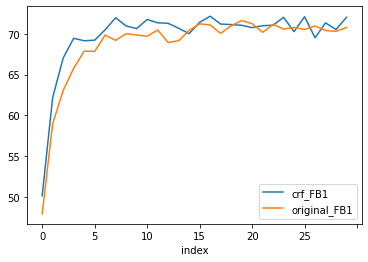

In [10]:
table1.plot(x = 'index', y = ['crf_FB1', 'original_FB1'])

<AxesSubplot:xlabel='index'>

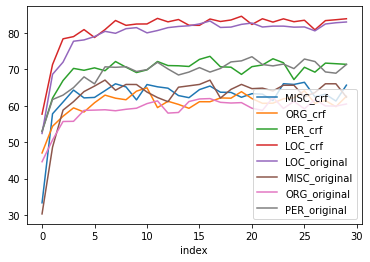

In [65]:
df.plot(x = 'index', y = ['MISC_crf', 'ORG_crf', 'PER_crf', 'LOC_crf', 'LOC_original', 'MISC_original', 'ORG_original', 'PER_original'])

In [64]:
df

,index,MISC_crf,ORG_crf,PER_crf,LOC_crf,LOC_original,MISC_original,ORG_original,PER_original
0,0,33.33,47.04,53.00,57.71,52.40,30.28,44.63,52.93
1,1,57.81,54.38,62.11,71.34,68.66,48.63,50.61,61.73
2,2,61.04,57.14,66.95,78.42,72.01,58.82,55.69,62.94
3,3,64.33,59.44,70.29,79.03,77.76,61.15,55.74,65.01
4,4,62.18,58.30,69.77,80.96,78.12,63.92,58.75,67.96
5,5,62.31,60.84,70.44,78.79,79.04,65.43,58.82,66.04
6,6,64.17,62.94,69.65,80.96,80.48,67.08,58.92,70.72
7,7,66.06,62.10,72.18,83.46,79.94,64.29,58.64,70.59
8,8,65.20,61.67,70.62,82.13,81.21,65.88,59.05,70.75
9,9,61.63,64.03,69.15,82.49,81.50,65.86,59.34,69.44
